# Machine Learning Pipeline - Should this be a challenge?

**[Big Data and Cloud Computing]**

## Group D
* Daniela Tomás, up202004946
* Diogo Nunes, up202007895
* Diogo Almeida, up202006059

## References
* https://stackoverflow.com/questions/59659344/how-to-process-faster-on-gz-files-in-spark-scala
* https://stackoverflow.com/questions/61961123/my-bar-plot-is-not-showing-bars-for-all-the-data-values

## PySpark Setup
Firstly, we import the necessary libraries, packages and methods.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
import os

Spark requires the JAVA_HOME environment variable to be set

In [ ]:
#os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-21.0.3.0.9-1.fc40.x86_64/'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_MASTER_HOST'] = 'localhost'

Spark can be configured with lots of settings.  
In particular we highlight the "local[*]" which configures spark to run in standalone mode, so everything is running in the local machine, using all available threads.

In [3]:
spark = SparkSession.builder \
    .appName("ICU_Length_of_Stay_Prediction") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()
sc = spark.sparkContext

In [6]:
file_path = "dataset/CHARTEVENTS.parquet"

df = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

df.printSchema()
df.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

+-------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
| ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+-------+----------+-------+----------+------+-------------------+-----------------

In [4]:
icu_file_path = "dataset/ICUSTAYS.parquet"

df_icustays = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(icu_file_path)

df_icustays.printSchema()
df_icustays.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- DBSOURCE: string (nullable = true)
 |-- FIRST_CAREUNIT: string (nullable = true)
 |-- LAST_CAREUNIT: string (nullable = true)
 |-- FIRST_WARDID: integer (nullable = true)
 |-- LAST_WARDID: integer (nullable = true)
 |-- INTIME: timestamp (nullable = true)
 |-- OUTTIME: timestamp (nullable = true)
 |-- LOS: double (nullable = true)

+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|   LOS|
+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+------+
|   365|       268| 110404|    280836| carev

In [5]:
d_icd_diagnoses_file_path = "dataset/D_ICD_DIAGNOSES.parquet"

df_d_icd_diagnoses = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(d_icd_diagnoses_file_path)

df_d_icd_diagnoses.printSchema()
df_d_icd_diagnoses.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- ICD9_CODE: string (nullable = true)
 |-- SHORT_TITLE: string (nullable = true)
 |-- LONG_TITLE: string (nullable = true)

+------+---------+--------------------+--------------------+
|ROW_ID|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+---------+--------------------+--------------------+
|   174|    01166|TB pneumonia-oth ...|Tuberculous pneum...|
|   175|    01170|TB pneumothorax-u...|Tuberculous pneum...|
|   176|    01171|TB pneumothorax-n...|Tuberculous pneum...|
|   177|    01172|TB pneumothorx-ex...|Tuberculous pneum...|
|   178|    01173|TB pneumothorax-m...|Tuberculous pneum...|
+------+---------+--------------------+--------------------+
only showing top 5 rows



In [5]:
patients_file_path = "dataset/PATIENTS.parquet"

df_patients = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(patients_file_path)

df_patients.printSchema()
df_patients.show(5)

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- GENDER: string (nullable = true)
 |-- DOB: timestamp (nullable = true)
 |-- DOD: timestamp (nullable = true)
 |-- DOD_HOSP: timestamp (nullable = true)
 |-- DOD_SSN: timestamp (nullable = true)
 |-- EXPIRE_FLAG: integer (nullable = true)

+------+----------+------+-------------------+-------------------+-------------------+-------+-----------+
|ROW_ID|SUBJECT_ID|GENDER|                DOB|                DOD|           DOD_HOSP|DOD_SSN|EXPIRE_FLAG|
+------+----------+------+-------------------+-------------------+-------------------+-------+-----------+
|   234|       249|     F|2075-03-13 00:00:00|               NULL|               NULL|   NULL|          0|
|   235|       250|     F|2164-12-27 00:00:00|2188-11-22 00:00:00|2188-11-22 00:00:00|   NULL|          1|
|   236|       251|     M|2090-03-15 00:00:00|               NULL|               NULL|   NULL|          0|
|   237|       252|     M|2

## Data understanding and preparation

In [6]:
print(f'{df.count()} rows and {len(df.columns)} cols')

330712483 rows and 15 cols


In [19]:
df.describe("VALUENUM").show()

+-------+------------------+
|summary|          VALUENUM|
+-------+------------------+
|  count|         146504168|
|   mean| 71.82548549626641|
| stddev|2047.6643228137305|
|    min|          -10069.0|
|    max|         9999999.0|
+-------+------------------+



### Total event count

In [12]:
events_count_df = df.groupBy("SUBJECT_ID").agg(count("*").alias("total_events"))
events_count_df.describe("total_events").show()

+-------+------------------+
|summary|      total_events|
+-------+------------------+
|  count|             46467|
|   mean| 7117.147287322186|
| stddev|14779.275677390777|
|    min|                 3|
|    max|            775024|
+-------+------------------+



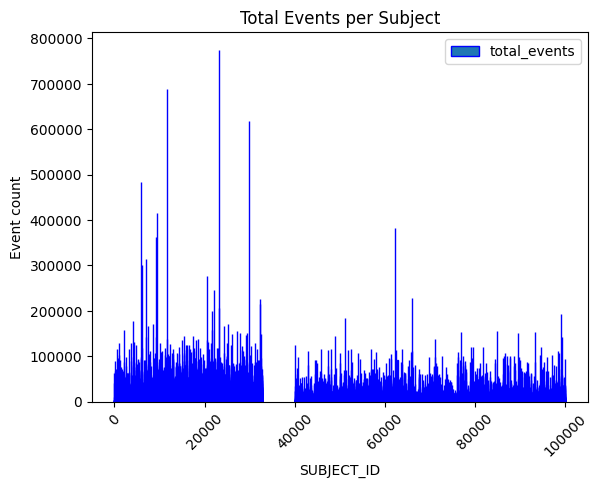

In [33]:
y = [val.total_events for val in events_count_df.select('total_events').collect()]
x = [val.SUBJECT_ID for val in events_count_df.select('SUBJECT_ID').collect()]

plt.bar(x, y, ec='blue')
plt.ylabel('Event count')
plt.xlabel('SUBJECT_ID')
plt.title('Total Events per Subject')
plt.legend(['total_events'], loc='upper right')
plt.xticks(rotation=45) 
plt.show()

Here we can clearly see what looks like an irregularity in the dataset, so lets dive deeper...

In [63]:
filtered_events_count_df = events_count_df.where(col("SUBJECT_ID").between(32810, 40000))
filtered_events_count_df.show(10)

+----------+------------+
|SUBJECT_ID|total_events|
+----------+------------+
|     32810|       39128|
|     40000|       16710|
+----------+------------+



We can see here clearly that IDs between 32810 and 40000 arent recorded here, lets try to find why.

In [71]:
filtered_df = df.where(col("SUBJECT_ID").between(32811, 39999))
filtered_df.show(10)

+------+----------+-------+----------+------+---------+---------+----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|CHARTTIME|STORETIME|CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+---------+---------+----+-----+--------+--------+-------+-----+------------+-------+
+------+----------+-------+----------+------+---------+---------+----+-----+--------+--------+-------+-----+------------+-------+



The IDs dont even exist!
seeing as they aren't even recorded, theres nothing to process and so theres nothing to do

### Number of Admissions (NoA)

In [5]:
noa_df = df.groupBy("SUBJECT_ID").agg(countDistinct("HADM_ID").alias("NUMBER_OF_ADMISSIONS"))
noa_df.describe("NUMBER_OF_ADMISSIONS").show()

+-------+--------------------+
|summary|NUMBER_OF_ADMISSIONS|
+-------+--------------------+
|  count|               46467|
|   mean|  1.2325306131232918|
| stddev|  0.8467634142511434|
|    min|                   1|
|    max|                  41|
+-------+--------------------+



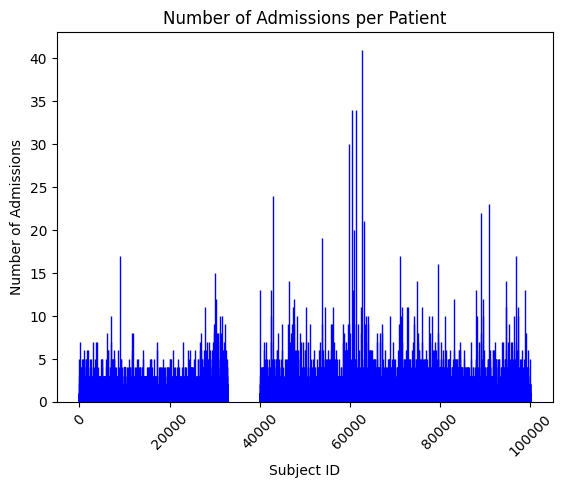

In [6]:
subject_ids = [row.SUBJECT_ID for row in noa_df.select("SUBJECT_ID").collect()]
num_admissions = [row.NUMBER_OF_ADMISSIONS for row in noa_df.select("NUMBER_OF_ADMISSIONS").collect()]

plt.bar(subject_ids, num_admissions, ec='blue') 
plt.ylabel('Number of Admissions')
plt.xlabel('Subject ID')
plt.title('Number of Admissions per Patient')
plt.xticks(rotation=45)
plt.show()

To determine if there is subjects with more than one hospital admission, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``HADM_IDs`` for each ``SUBJECT_ID``. 

We discovered that 6515 patients had more than one hospital admission.

In [14]:
subjects_multiple_admissions_df = noa_df.where(col("NUMBER_OF_ADMISSIONS") > 1)
subjects_multiple_admissions_df.describe("NUMBER_OF_ADMISSIONS").show()

percentage_multiple_admissions = "{:.2f}".format(subjects_multiple_admissions_df.count() / noa_df.count() * 100)

print( "The percentage of patients that had multiple hospital admissions is " + percentage_multiple_admissions + "%")

+-------+--------------------+
|summary|NUMBER_OF_ADMISSIONS|
+-------+--------------------+
|  count|                6515|
|   mean|  2.6584804297774367|
| stddev|    1.65810959886756|
|    min|                   2|
|    max|                  41|
+-------+--------------------+



The percentage of patients that had multiple hospital admissions is 14.02%


To determine if there is subjects with more than one ICU stay, we do a groupBy operation on the ``SUBJECT_ID`` column and then count the number of unique ``ICUSTAY_IDs`` for each ``SUBJECT_ID``. 

We discovered that 8436 patients had more than one ICU stay.

In [76]:
subjects_multiple_icu_stays = df.groupBy("SUBJECT_ID").agg(countDistinct("ICUSTAY_ID").alias("NUM_ICU_STAYS")).filter(col("NUM_ICU_STAYS") > 1)
subjects_multiple_icu_stays.describe("NUM_ICU_STAYS").show()

+-------+------------------+
|summary|     NUM_ICU_STAYS|
+-------+------------------+
|  count|              8436|
|   mean|2.7072072072072073|
| stddev|1.6789361311614799|
|    min|                 2|
|    max|                41|
+-------+------------------+



### Patients

In [6]:
df_patients.groupBy("GENDER").count().show()

+------+-----+
|GENDER|count|
+------+-----+
|     F|20399|
|     M|26121|
+------+-----+



In [8]:
df_patients.groupBy("EXPIRE_FLAG").count().show()

+-----------+-----+
|EXPIRE_FLAG|count|
+-----------+-----+
|          1|15759|
|          0|30761|
+-----------+-----+



In [17]:
expired_patients_df = df_patients.filter(df_patients.EXPIRE_FLAG == 1)

expired_patients_df = expired_patients.withColumn("AGE_AT_DEATH", 
    (datediff(col("DOD"), col("DOB")) / 365.25).cast(IntegerType())
)
expired_patients.select("AGE_AT_DEATH").describe().show()

+-------+-----------------+
|summary|     AGE_AT_DEATH|
+-------+-----------------+
|  count|            15759|
|   mean|91.48156608921886|
| stddev| 68.9326419427184|
|    min|                0|
|    max|              310|
+-------+-----------------+



There are 300 year old patients!!

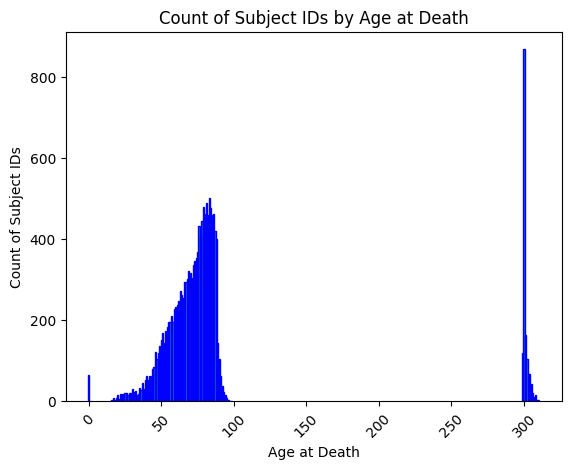

In [19]:
age_counts = expired_patients.groupBy("AGE_AT_DEATH").count()
age_counts_data = age_counts.collect()
ages = [row['AGE_AT_DEATH'] for row in age_counts_data]
counts = [row['count'] for row in age_counts_data]

plt.bar(ages, counts, ec='blue')
plt.ylabel('Count of Subject IDs')
plt.xlabel('Age at Death')
plt.title('Count of Subject IDs by Age at Death')
plt.xticks(rotation=45)
plt.show()

For privacy reasons, the date of birth (DOB) of patients above the age of 89 was shifted. The patient's age at first admission was calculated and the DOB was adjusted 300 years before their first admission date.

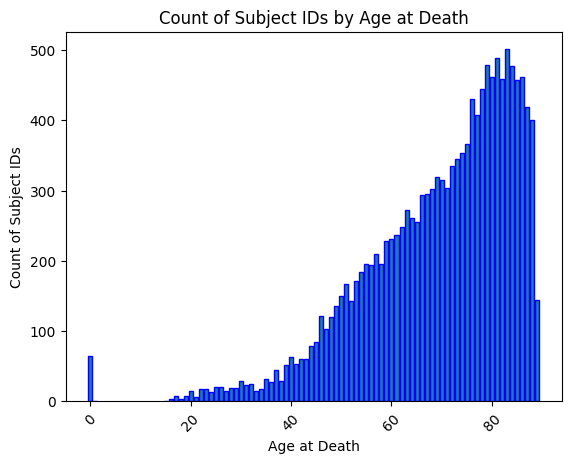

In [22]:
expired_patients_filtered = expired_patients.filter(col("AGE_AT_DEATH") <= 89)
age_counts = expired_patients_filtered.groupBy("AGE_AT_DEATH").count()
age_counts_data = age_counts.collect()
ages = [row['AGE_AT_DEATH'] for row in age_counts_data]
counts = [row['count'] for row in age_counts_data]

plt.bar(ages, counts, ec='blue')
plt.ylabel('Count of Subject IDs')
plt.xlabel('Age at Death')
plt.title('Count of Subject IDs by Age at Death')
plt.xticks(rotation=45)
plt.show()

It is impossible to determine the real age of these patients. Therefore, we have decided to remove them.

In [ ]:
expired_patients_df = expired_patients_filtered

### Missing Values

In [14]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|CHARTTIME|STORETIME|   CGID|  VALUE| VALUENUM| VALUEUOM|  WARNING|    ERROR|RESULTSTATUS|  STOPPED|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+
|     0|         0|      0|    297529|     0|        0|  6312672|6312672|2071349|184208315|213982888|221315841|221315841|   321182823|110282285|
+------+----------+-------+----------+------+---------+---------+-------+-------+---------+---------+---------+---------+------------+---------+



### Duplicate Values

There are no duplicates in the dataset.

In [5]:
#duplicate_rows_count = df.count() - df.distinct().count()
#ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED
duplicate_cols = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'STORETIME', 'CGID', 'VALUE' ]
df.groupBy(duplicate_cols)\
    .count()\
    .where(col('count') > 1)\
    .select(sum('count'))\
    .show()



#+----------+
#|sum(count)|
#+----------+
#|      NULL|
#+----------+

24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/11 18:25:43 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+
|sum(count)|
+----------+
|  87792079|
+----------+



In [9]:
spark.stop()